## Importing libraries

In [2]:
import pandas as pd
from sklearn import datasets # sklearn comes with some toy datasets to practise
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import sys
import yaml
from pprint import pprint
import json
import argparse
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns

In [3]:
df = pd.read_excel("df_original.xlsx")

In [4]:
df.shape

(157835, 15)

In [5]:
df.head(5)

,artists,danceability,duration_ms,energy,genres,instrumentalness,liveness,loudness,speechiness,tempo,track_id,track_name,valence,year,decades
0,ottorino respighi,0.420,232933,0.0909,"['classical', 'early modern classical', 'impre...",1,0,-19.388,0.0409,123089.000,0pdgc1WRsbipUSUOMqwxO4,"la boutique fantasque, p. 120 (after rossini):...",0.227,1950,1950's
1,percy faith & his orchestra,0.357,141800,0.5330,"['adult standards', 'easy listening', 'lounge']",0,0,-11814.000,0.0366,168546.000,0pkeWCwt70V4p692BTCldS,flight 33 1/3,0.793,1950,1950's
2,mohammed rafi,0.464,188016,266.0000,"['classic bollywood', 'desi pop', 'filmi', 'gh...",0,0,-13.004,0.0905,129486.000,0pqBe1Xk24ak8TaAEJNiA1,bahot purdard hai ae sunnewalo,537.000,1950,1950's
3,sotiria bellou,622.000,195280,594.0000,"['entehno', 'laiko', 'rebetiko']",0,0,-6.134,0.0456,95.300,0prp5MDuNtlrm4bOFgrwhO,μια φορά στον κόσμο ζούμε,885.000,1950,1950's
4,alekos kitsakis,522.000,207467,596.0000,['rebetiko'],0,0,-10329.000,0.0398,102.923,0qC2ryicx1eOhHKMttE5UW,kainourgia logia mou hrthane,877.000,1950,1950's


In [6]:
#form training data by excluding columns that aren't audio features
non_features = ["artists", "track_id", "track_name", "year", "decades", "genres", "duration_ms"]

In [7]:
track_info = df[non_features]
df_X = df.drop(columns=non_features)
df_X.head(5)

,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.420,0.0909,1,0,-19.388,0.0409,123089.000,0.227
1,0.357,0.5330,0,0,-11814.000,0.0366,168546.000,0.793
2,0.464,266.0000,0,0,-13.004,0.0905,129486.000,537.000
3,622.000,594.0000,0,0,-6.134,0.0456,95.300,885.000
4,522.000,596.0000,0,0,-10329.000,0.0398,102.923,877.000


In [8]:
df_X.shape

(157835, 8)

In [9]:
df_X.dtypes

danceability        float64
energy              float64
instrumentalness      int64
liveness              int64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
dtype: object

### Standardisation

In [10]:
# now we have to standardize the X_train data by putting the 8 features on the same scale
# each scale having a mean = 0 and a SD = 1 
# if we wouldn't do this, the model would weigh tempo or loudness much more, since they vary more than other variables 

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(df_X)

## Dimensionality Reduction
### Principal Component Analysis (PCA)

In [12]:
from sklearn.decomposition import PCA

In [17]:
# Principal Component Analysis (PCA) is a method to reduce dimensions (from 2d to 3d)
# it tries to find the best possible subspace that explains most of the variance in the data
# how? it derives components from the original scaled features and plots the 2 most significant ones 
pca = PCA()
pca.fit(X_train)


PCA()

### **How many features to use for our k-means?**

Make a cumulative variance plot using the evr.cumsum() function and plt.

In [14]:
evr = pca.explained_variance_ratio_
evr

array([0.18254203, 0.13259116, 0.13071049, 0.12585235, 0.11533626,
       0.11463714, 0.10810806, 0.09022251])

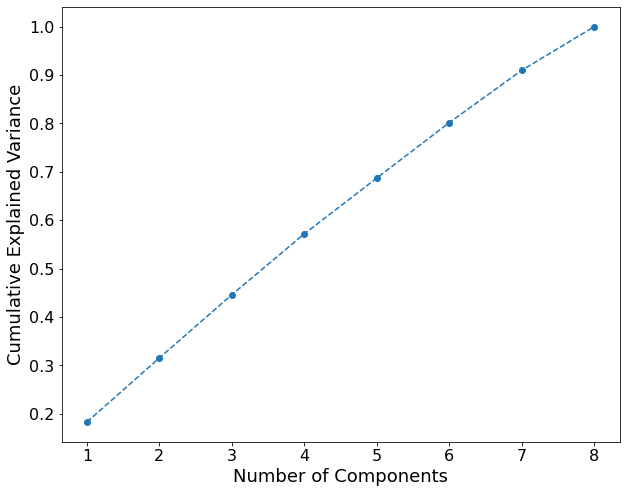

In [15]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(df_X.columns)+1), evr.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Cumulative Explained Variance',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#fig = plt.savefig("./visualizations/cumulative_variance_plot.png")
plt.show()

In [16]:
for i, exp_var in enumerate(evr.cumsum()):
    if exp_var >= 0.8:
        n_comps = i + 1
        break
print("Number of components:", n_comps)
pca = PCA(n_components=n_comps)
pca.fit(X_train)
scores_pca = pca.transform(X_train)

Number of components: 6


#### **Conclusion**

From this plot, we can observe that each of the principal components explain a pretty considerable amount of variance. However, we do not need to keep all of these components. 
In general, it is a good rule of thumb to preserve around 80% of the variance. Therefore, in this instance, we can select the 6 most important principal components to incorporate in the k-means algorithm. This can be accomplished by instantiating a new PCA object with the n_components parameter set to 6.

# K-Means Clustering

Having finished our PCA, we now have components which explain most of the variance in the data. 

Now it's very difficult to interpret meaning when analyzing the numeric differences in tracks because the vectorized audio features have been transformed into a new subspace. 

However, after implementing k-means Clustering, we will be able to inspect the raw data, and we can even visualize our clusters of similar songs on the same 2D-plane.

### How to determine the optimal number of clusters (=k)?
(https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb)

#### Elbow Method 

Now we need to find the elbow point of the **WCSS (within cluster sum of squares) curve**. This can also be done using the YellowBrick --> KElbowVisualizer (from kneed import KneeLocator)

Training a K-Means model with 2 neighbours! 

Training a K-Means model with 3 neighbours! 

Training a K-Means model with 4 neighbours! 

Training a K-Means model with 5 neighbours! 

Training a K-Means model with 6 neighbours! 

Training a K-Means model with 7 neighbours! 

Training a K-Means model with 8 neighbours! 

Training a K-Means model with 9 neighbours! 

Training a K-Means model with 10 neighbours! 

Training a K-Means model with 11 neighbours! 

Training a K-Means model with 12 neighbours! 

Training a K-Means model with 13 neighbours! 

Training a K-Means model with 14 neighbours! 

Training a K-Means model with 15 neighbours! 

Training a K-Means model with 16 neighbours! 

Training a K-Means model with 17 neighbours! 

Training a K-Means model with 18 neighbours! 

Training a K-Means model with 19 neighbours! 

Training a K-Means model with 20 neighbours! 



Text(0.5, 1.0, 'Elbow Method showing the optimal k')

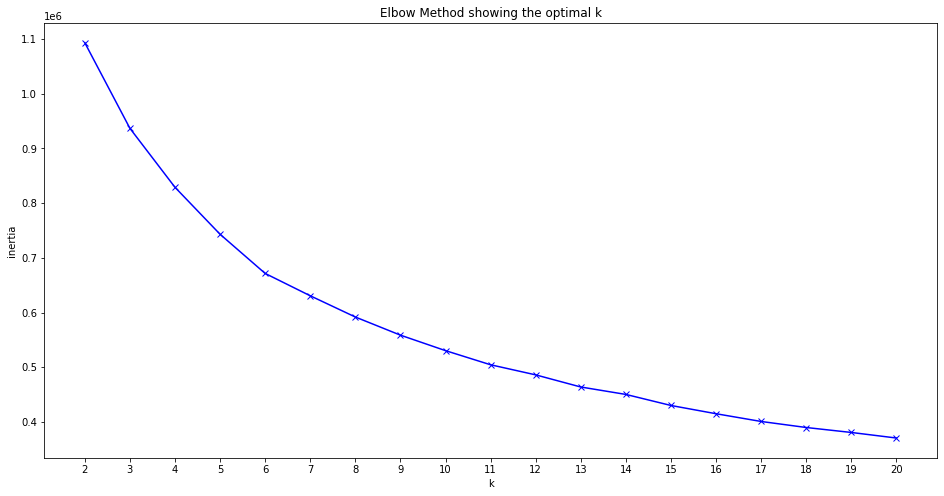

In [24]:
#Implement clustering algorithm for varying values of k, ranging from 1 to 20 clusters.
K = range(2, 21)
inertia = []

for k in K:
    print("Training a K-Means model with {} neighbours! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_train)
    inertia.append(kmeans.inertia_) #For each k the (WCSS) is computed by storing the inertia value in a list

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the WCSS curve according to the number of clusters k.
#Look for a kink or elbow in the graph

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

#### **Conclusion:**
There seems to be an elbow at **k=6**, and then a very slight one at k=10, but other than that the plot is quite smooth. What if we need to have a k with more clusters?

There is another metric that will help us decide.

## Silhouette

There's a metric called **Silhouette Score** that also measures how similar is an observation is to its own cluster (=cohesion) compared to other clusters (=seperation). For the i'th observation, the **Silhouette Score** is:

$$s_{K,L} = (b - a) / max(a,b) $$

Where:

a = mean intra-cluster distance (the average distance between i and every other observation in the cluster where i belongs)

$$ a = \frac{1}{n_{K}}\sum_{i,j\neq{i}}^{n_{K}}d(i,j)$$

b = mean **nearest-cluster** distance (the average distance between i and the observations of the nearest cluster that i is not part of it)

$$ b = \frac{1}{(n_{K}*n_{L})}\sum_{i}^{n_{K}}\sum_{j}^{n_{L}}d(i,j)$$

The silhouette score for the whole model is the **average of all the silhouette scores** of each instance.

$$ S = \frac{2}{N(N-1)}\sum_{c}s_{K,L}$$

Because we divide the substraction of (b-a) by the max of the two distances (which will always be b unless the observation has been wrongly assigned to a cluster it should not belong), we obtain a "normalized score", that ranges from -1 to 1, and that makes it easier to interpret.

In [26]:
import pickle

#fraction = X_train.sample(n=1000)

K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_train.sample)
    #kmeans.fit(X_train.sample)
 #   filename = "kmeans" + str(k) + ".pickle"
  #  with open(filename, "wb") as f:
   #     pickle.dump(kmeans,f)
    silhouette.append(silhouette_score(X_train, kmeans.predict(X_train)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

AttributeError: 'numpy.ndarray' object has no attribute 'sample'

In [27]:
s = [0.26,0.28,0.24,0.247]
s.index(max(s))

1

In [ ]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(X_train)
  labels = kmeans.labels_
  sil.append(silhouette_score(X_train, labels, metric = 'euclidean'))

The greater the Silouhette, the greater the separation between the clusters, In other words, the clusters will be more defined.

Here, we confirm that 3 is the best option, but we also notice that 5 a quite good - it meets the 'technical criteria' of having a better score than its predecessor (4), so if it falls within the range of our business demands - it looks like the best candidate.

**Conclusion:** The range of the Silhouette value is between **+1** and **-1**. A **high value is desirable** and indicates that the point is placed in the correct cluster. If many points have a **negative Silhouette value**, it may indicate that we have created **too many or too few clusters**. The Silhouette Score reaches its **global maximum at the optimal k**. This should ideally appear as a **peak** in the Silhouette Value-versus-k plot.

In [28]:
#Now, we implement k-means clustering with the help of sklearn by obtaining the cluster labels for each track 
#At the rightmost column "Cluster", we will find the according cluster number for each row 
n_clusters=15

kmeans_pca = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans_pca.fit(scores_pca)
kmeans_pca

KMeans(n_clusters=15, random_state=42)

## Analysis and Visualization

In [29]:
df_seg_pca_kmeans = pd.concat([df_X.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
df_seg_pca_kmeans.columns.values[(-1*n_comps):] = ["Component " + str(i+1) for i in range(n_comps)]
df_seg_pca_kmeans['Cluster'] = kmeans_pca.labels_

In [30]:
df_seg_pca_kmeans.head()

,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Cluster
0,0.420,0.0909,1,0,-19.388,0.0409,123089.000,0.227,1.563223,-0.198841,1.416860,-0.448588,0.573431,-0.089171,11
1,0.357,0.5330,0,0,-11814.000,0.0366,168546.000,0.793,1.277938,0.081140,1.018380,-0.313551,0.825968,1.383915,11
2,0.464,266.0000,0,0,-13.004,0.0905,129486.000,537.000,-0.627562,-0.354950,0.734371,-0.974094,0.132424,1.296285,5
3,622.000,594.0000,0,0,-6.134,0.0456,95.300,885.000,-1.844349,-0.651318,-1.325071,-0.468850,-1.022088,-0.479152,3
4,522.000,596.0000,0,0,-10329.000,0.0398,102.923,877.000,-0.893269,-0.457945,-1.380512,-0.150470,-1.268281,-0.099211,3


## Checking sensical separation of data with Scatterplot

In [31]:
# Take the Components from above and put them in a scatterplot

/Users/testaccount/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


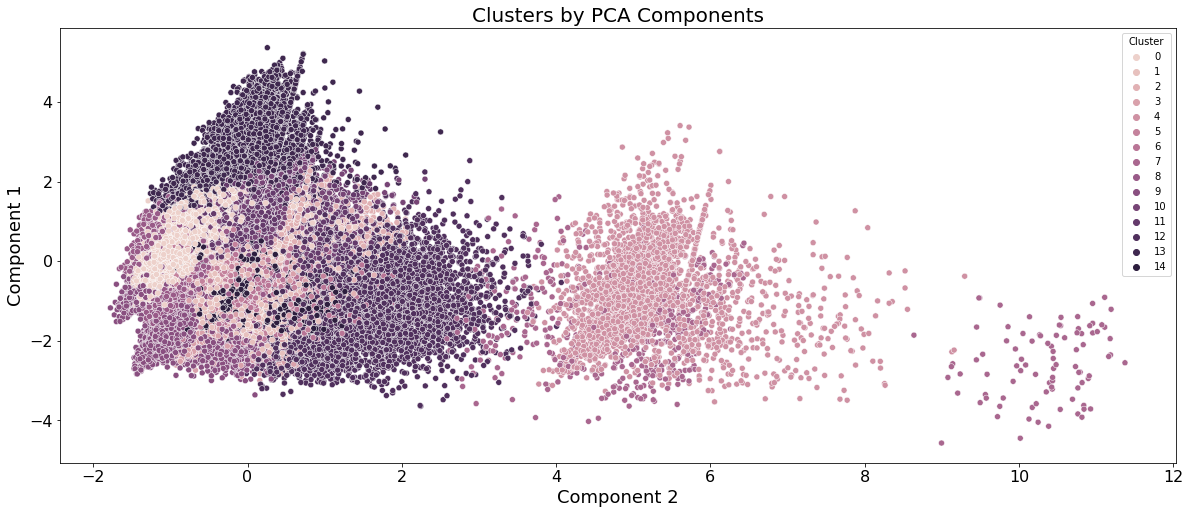

In [42]:
x = df_seg_pca_kmeans['Component 2'] #1d
y = df_seg_pca_kmeans['Component 1'] #2D (n-D...cant be visualised)
fig = plt.figure(figsize=(20, 8))

sns.scatterplot(x, y, hue=df_seg_pca_kmeans['Cluster'], legend= "full")

plt.title('Clusters by PCA Components', fontsize=20)
plt.xlabel("Component 2", fontsize=18)
plt.ylabel("Component 1", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
#fig.savefig("./visualizations/clusters-2d.png")

**Conclusion:**
While k-means clustering is not a supervised machine learning technique—meaning, we cannot verify whether the results are accurate or not.
However, we can visualize the clusters on a 2D plane (instead of a 6D plane) to ensure that there is some sensical separation of data based on the sources of signals that are encapsulated by the components. 

In the **figure above**, it is clear that Cluster 0 is most similar to Clusters 1, 2 and 5. Cluster 3 is quite loosely defined, overlapping with a few other clusters. Despite some noise, there are clear groupings of tracks, as indicated by the concentrated areas of green, red, orange, and blue data points. 

In [33]:
df['Cluster'] = df_seg_pca_kmeans['Cluster']
df.head()

,artists,danceability,duration_ms,energy,genres,instrumentalness,liveness,loudness,speechiness,tempo,track_id,track_name,valence,year,decades,Cluster
0,ottorino respighi,0.420,232933,0.0909,"['classical', 'early modern classical', 'impre...",1,0,-19.388,0.0409,123089.000,0pdgc1WRsbipUSUOMqwxO4,"la boutique fantasque, p. 120 (after rossini):...",0.227,1950,1950's,11
1,percy faith & his orchestra,0.357,141800,0.5330,"['adult standards', 'easy listening', 'lounge']",0,0,-11814.000,0.0366,168546.000,0pkeWCwt70V4p692BTCldS,flight 33 1/3,0.793,1950,1950's,11
2,mohammed rafi,0.464,188016,266.0000,"['classic bollywood', 'desi pop', 'filmi', 'gh...",0,0,-13.004,0.0905,129486.000,0pqBe1Xk24ak8TaAEJNiA1,bahot purdard hai ae sunnewalo,537.000,1950,1950's,5
3,sotiria bellou,622.000,195280,594.0000,"['entehno', 'laiko', 'rebetiko']",0,0,-6.134,0.0456,95.300,0prp5MDuNtlrm4bOFgrwhO,μια φορά στον κόσμο ζούμε,885.000,1950,1950's,3
4,alekos kitsakis,522.000,207467,596.0000,['rebetiko'],0,0,-10329.000,0.0398,102.923,0qC2ryicx1eOhHKMttE5UW,kainourgia logia mou hrthane,877.000,1950,1950's,3


In [37]:
df["Cluster"].unique()

array([11,  5,  3,  8,  2, 13,  6, 14,  9, 12, 10,  0,  1,  7,  4],
      dtype=int32)

In [35]:
df.to_csv("results_clusters_11")

## Radar Chart

Since meaning cannot be inferred from the transformed components, let’s **take a look at the raw values for the audio features** of the tracks after they have been clustered. A **radar chart can be really powerful** in this type of analysis because it allows us to make some quick observations about each cluster.

### Normalisation 

Normalization is important because it effectively scales all variables to have values between 0 and 1, making the following visualization far more meaningful.

In [ ]:
def make_normalized_df(df, col_sep):
    non_features = df[df.columns[:col_sep]]
    features = df[df.columns[col_sep:]]
    norm = MinMaxScaler().fit_transform(features)
    scaled = pd.DataFrame(norm, index=df.index, columns = df.columns[col_sep:])
    return pd.concat([non_features, scaled], axis=1)

cluster_labels = df['Cluster']
orig = df.drop(columns=['playlist', 'Cluster'])
values_df = make_normalized_df(orig, 3)
values_df.insert(3, 'cluster', cluster_labels)


In [ ]:
values_df.head()

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=2, cols=4, specs=[[{'type': 'polar'}]*4]*2)

angles = list(values_df.columns[4:])
angles.append(angles[0])
abbrev = ["A", "D", "E", "I", "Li", "Lo", "S", "T", "V"]

layoutdict = dict(
            radialaxis=dict(
            visible=True,
            range=[0, 1]
            ))

for i in range(n_clusters):
    subset = values_df[values_df['cluster'] == i]
    data = [np.mean(subset[col]) for col in subset.columns[4:]]
    data.append(data[0])
    fig.add_trace(go.Scatterpolar(
        r=data,
        theta=abbrev,
        fill='toself',
        name="Cluster " + str(i)),
        i // 4 + 1,
        i % 4 + 1)
    
fig.update_layout(
        polar=layoutdict,
        polar2=layoutdict,
        polar3=layoutdict,
        polar4=layoutdict,
        polar5=layoutdict,
        polar6=layoutdict,
        polar7=layoutdict,
        polar8=layoutdict,
        showlegend=True
        )
fig.show()

## Bar Chart 

Finally, there is one last thing we can do to analyze the findings. We can make some bar charts, plotting a particular feature for each track in a given cluster in order to see if this feature is, indeed, characteristically high with respect to the average feature value in the entire dataset.

In [ ]:
def inspect(df, param, cluster):
    plt.figure(figsize=(10,8))
    test_cluster = df.loc[df['Cluster'] == cluster]
    y = test_cluster[param]
    x = [i for i in range(len(y))]
    plt.bar(x, y)
    plt.xlabel('Track #', fontsize=18)
    plt.ylabel(param.title(), fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.hlines(np.mean(df[param]), 0, len(y))
    plt.show()
    
inspect(df, "liveness", 0)

In [ ]:
clusters = [0, 1, 2, 3, 4, 5]
features = ["liveness", "speechiness", "instrumentalness"]
colors = ['green', 'olive', 'cyan']
dim = len(clusters)

fig, axes = plt.subplots(dim, dim, figsize=(24, 12))
i = 0
test_cluster = df.loc[df['Cluster'] == clusters[0]]
for ax in (axes.flatten()):
    if i % dim == 0 and i != 0:
        test_cluster = df.loc[df['Cluster'] == clusters[i // dim]]
    col = features[i % dim]
    y = test_cluster[col]
    x = [i for i in range(len(y))]
    ax.bar(x, y, color=colors[i//dim])
    ax.set_ylabel(col, fontsize=14)
    ax.set_title("Cluster " + str(clusters[i // dim]), fontsize=16)
    ax.hlines(np.mean(df[col]), 0, len(y))
    plt.subplots_adjust(wspace=.5, hspace=.5)
    i += 1
    
#fig.savefig("./visualizations/cluster_feature_bar_charts_dim_3.png")

--------------------------------------------------

## Loading the sklearn's wines dataset

In [ ]:
data = datasets.load_wine()

# Let's see what we have.
#display(data)
# OMG! Another dictionary!!!

# We will not use the 'target' key as we don't want to classify the wines in types.
# we just want to cluster them.
X = pd.DataFrame(data["data"], columns=data["feature_names"])

print()
X.head()

In [ ]:
data['DESCR']

In [ ]:
data['data']

In [ ]:
data['feature_names']

## Scaling features

In [ ]:
X.describe()

The scale of "proline" is much bigger than the scale of many other variable!

**K-Means is a distance based algorithm**: we need to scale / normalize!:

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
display(X.head())
print()
display(X_scaled_df.head())

In [ ]:
X_scaled_df.describe()

Now, all features will have the same weight.

In [ ]:
pd.DataFrame(X_prep, columns=X.columns).head()

In [ ]:
pd.DataFrame(X_prep, columns=X.columns).describe()

## Clustering the wines with K-Means

We will pick manually the number of clusters we want - let's set it to 8. Later we will discuss how many clusters should we have.

When randomness is involved (remember, **K-means picks randomly the initial centroids**), we better use a random seed so that we can reproduce our results. We can set this directly to the argument **random_state**.

In [ ]:
kmeans = KMeans(n_clusters=8, random_state=1234)
kmeans.fit(X_scaled_df)

Now we have our "model", let's get the clusters and how many observations has each cluster.



In [ ]:
clusters = kmeans.predict(X_scaled_df)
#clusters
pd.Series(clusters).value_counts().sort_index()

Now let's see to which group was assigned every wine.

In [ ]:
#X_df = pd.DataFrame(X)
X["cluster"] = clusters
X.head()

In [ ]:
X[X['cluster'] == 7].sample()

## Playing with the parameters

**init**: those are the different initialization strategies. By default, sklearn is already using a 'smart' method, not the totally random one we saw.

**n_init**: By default, Scikit-Learn has tried 10 different random initializations and kept the best model.

[Scikitlearn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

How does Scikit-Learn know which model is the best? It uses a performance metric called **inertia**. **It is the mean squared distance between each instance and its closest centroid**. It's stored in the inertia_ attribute of the model.

In [ ]:
kmeans.inertia_

**max_iter**: It iterates up to 300 times by default (those are the re-computing centroids iterations we saw earlier)

**tol**: This is a way to determine when to stop iterating (if the clusters have changed only veeeery slightly, we assume we have achieved 'convergence')

**algorithm**: There are variations in the implementation of most algorithms and K-Means is no exception. By default, we're using a 'smart' implementation called elkan.

For learning purposes, we will tweak the parameters to replicate the good ol' K-Means - a bit dumber than the Scikit-Learn, yes, but also the original.

In [ ]:
kmeans2 = KMeans(n_clusters=8,
                init="random",
                n_init=3,  # try with 1, 4, 8, 20, 30, 100...
                max_iter=2,
                tol=0,
                algorithm="full",
                random_state=1234)
kmeans2.fit(X_scaled_df)
print(kmeans2.inertia_)

## Chosing K

We have used K=8 by default for now - but we know that 8 might not be the optimal number of clusters for our dataset. Having a metric like inertia, we can compute it for several K values and then use the "elbow method" to choose the best K.

We will now leave all other parameters with their default value, since it seems to work pretty well.

In [ ]:
K = range(2, 21)
inertia = []

for k in K:
    print("Training a K-Means model with {} neighbours! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_scaled_df)
    inertia.append(kmeans.inertia_)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

There seems to be an elbow at **k=3**, and then a very slight one at k=10, but other than that the plot is quite smooth. What if our business needs involv having a k between 5 and 8?

There is another metric that will help us decide.

## Silouhette

There's a metric called **Silhouette Score** that also measures how similar is an observation is to its own cluster compared to other clusters. For the ith observation, the **Silhouette Score** is:

$$s_{K,L} = (b - a) / max(a,b) $$

Where:

a = mean intra-cluster distance (the average distance between i and every other observation in the cluster where i belongs)

$$ a = \frac{1}{n_{K}}\sum_{i,j\neq{i}}^{n_{K}}d(i,j)$$

b = mean **nearest-cluster** distance (the average distance between i and the observations of the nearest cluster that i is not part of it)

$$ b = \frac{1}{(n_{K}*n_{L})}\sum_{i}^{n_{K}}\sum_{j}^{n_{L}}d(i,j)$$

The silhouette score for the whole model is the **average of all the silhouette scores** of each instance.

$$ S = \frac{2}{N(N-1)}\sum_{c}s_{K,L}$$

Because we divide the substraction of (b-a) by the max of the two distances (which will always be b unless the observation has been wrongly assigned to a cluster it should not belong), we obtain a "normalized score", that ranges from -1 to 1, and that makes it easier to interpret.

In [ ]:
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_scaled_df)
    filename = "/content/drive/MyDrive/kmeans_" + str(k) + ".pickle"
    with open(filename, "wb") as f:
        pickle.dump(kmeans,f)
    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

In [ ]:
s = [0.26,0.28,0.24,0.247]
s.index(max(s))

The greater the Silouhette, the greater the separation between the clusters, In other words, the clusters will be more defined.

Here, we confirm that 3 is the best option, but we also notice that 5 a quite good - it meets the 'technical criteria' of having a better score than its predecessor (4), so if it falls within the range of our business demands - it looks like the best candidate.

# Saving with pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pickle

#scaler = StandardScaler()
#model = KMeans()

with open("/content/drive/MyDrive/scaler.pickle", "wb") as f:
    pickle.dump(scaler,f)

with open("/content/drive/MyDrive/kmeans_4.pickle", "wb") as f:
    pickle.dump(kmeans,f)


In [ ]:
def load(filename = "filename.pickle"): 
    try: 
        with open(filename, "rb") as f: 
            return pickle.load(f) 
    except FileNotFoundError: 
        print("File not found!") 


In [ ]:
scaler2 = load("/content/drive/MyDrive/scaler.pickle")
scaler2

# Time to work!

Time to clusterize the songs in your database and see how they look like. 